In [66]:
# Functions for data import, processing, and plotting

def get_medium(start_year = '1971', end_year = '2014'):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import glob
    import sklearn.preprocessing
    %matplotlib inline
    np.set_printoptions(threshold=np.nan)

    files = glob.glob("C:\\Users\\Zach\\Sync\\ML Class\\Project\\Data\\World Bank\\*.csv")
    i = 0
    series = []
    for file in files:
        if file[-14:-4] == 'population':
            df = pd.read_csv(file, index_col = 0)
            series.append(file[52:-4])
        else:
            df = pd.read_csv(file, index_col = 0, skiprows = 4)
            series.append(file[52:-4])
        df.head()
        if i == 0:
            data = df.loc['World',start_year:end_year].reset_index().values
            i = 1
        elif file[-14:-4] == 'population':
            df = df[df['Country Code'].str.match('WLD')]

            data = np.concatenate((data,df[df['Year'].between(int(start_year),int(end_year))].values[:,2].reshape(-1,1)),axis = 1)
        else:
            data = np.concatenate((data,df.loc['World',start_year:end_year].values.reshape(-1,1)),axis = 1)

    data = data[0:,1:]
    ecopd = pd.read_csv("C:\\Users\\Zach\\Sync\\ML Class\\Project\\Data\\ecological_footprint.csv", index_col = 2)
    ecopd = ecopd.iloc[:,2:-2].drop(['Record'], axis = 1)
    data = np.concatenate((data[:,:], ecopd.loc[start_year:end_year,'Total'].values.reshape(-1,1)), axis = 1)
    series.append('ecological footprint')
    fossils = pd.read_csv("C:\\Users\\Zach\\Sync\\ML Class\\Project\\Data\\global-fossil-fuel-consumption.csv", index_col = 0)
    data = np.concatenate((data[:,:], fossils.loc[start_year:end_year,'Total'].values.reshape(-1,1)),axis = 1)
    series.append('fossil fuels')
    years = list(range(1971,1971+data.shape[0]))
    data = pd.DataFrame(data = data, columns = series, index = years)
    #data.to_csv(path_or_buf = "C:\\Users\\Zach\\Sync\\ML Class\\Project\\Data\\medium.csv" )
    return data

def get_big():
    df = pd.read_csv("C:\\Users\\Zach\\Sync\\ML Class\\Project\\Data\\world_data_1.csv")
    df = df.loc[:,:].replace('..', np.NaN)
    start_year = '1971'
    end_year = '2010'
    rows = np.where(np.prod(df.loc[:,start_year:end_year].notna().values, axis = 1))[0]
    df = df.iloc[rows,:]
    pred_steps = 14
    series = df.iloc[:,2].values
    df = df.loc[:,start_year:end_year]
    train = df.iloc[:,:].values.astype(float)
    years = df.loc[:,:].columns.values
    #train = pd.DataFrame(data = train.T, columns = series, index = years)
    med_data = get_medium(start_year, end_year)
    med_vals = med_data.values
    med_series = med_data.columns.values
    dat = np.concatenate([train.T, med_vals],axis = 1)
    series = np.concatenate([series, med_series])
    data = pd.DataFrame(data = dat, columns = series, index = years)
    return data

def transform_series(data, start_year, decoder_train_start, pred_years):
    decoder_train_start = decoder_train_start - start_year
    start_year = start_year - start_year
    scaler = sklearn.preprocessing.StandardScaler()
    data = scaler.fit_transform(data)

    encode = data[start_year:decoder_train_start+1,:].T
    encode = encode.reshape((encode.shape[0], -1, 1))
    
    decode = data[decoder_train_start+1:-pred_years,:].T
    decode = decode.reshape((decode.shape[0],-1, 1))
    
    target = data[-pred_years:,:].T
    target = target.reshape((target.shape[0],-1, 1))
    
    #mean_data = []

    return encode, decode, target, scaler

# def transform_series(data, start_year, decoder_train_start, pred_years):
#     decoder_train_start = decoder_train_start - start_year
#     start_year = start_year - start_year
#     data = data.values.astype(np.float64).T
#     data = np.log1p(np.nan_to_num(data)) # filling NaN with 0
#     mean_data = data.mean(axis=1).reshape(-1,1) 
#     data = data - mean_data
#     data = data.reshape((data.shape[0],data.shape[1], 1))
    
#     encode = data[:,start_year:decoder_train_start+1, :]
    
#     decode = data[:,decoder_train_start+1:-pred_years,:]
    
#     target = data[:,-pred_years:,:]

#     return encode, decode, target, mean_data


def reverse_transform(series_array,scaler):
#     series_array = series_array + encoder_series_mean[sample_ind]
#     series_array = np.expm1(np.nan_to_num(series_array))

    series_array = scaler.inverse_transform(series_array.T)
    return series_array

def predict_sequence(input_sequence,pred_steps):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((history_sequence.shape[0],pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[:,-1,0]
        pred_sequence[:,i,0] = last_step_pred
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

def predict_and_plot_all(encoder_input_data, decoder_target_data, pred_target_data, scaler, pred_steps, target_steps, 
                         start_year, series, sample_inds, enc_tail_len=50):
    encode_series = encoder_input_data[:,:,:]
    
    pred_series = predict_sequence(encode_series, pred_steps)
    encode_series = encode_series.reshape(-1,encode_series.shape[1])
    
    pred_series = pred_series.reshape(-1,pred_series.shape[1])
    
    target_series = decoder_target_data.reshape(-1,decoder_target_data.shape[1])
    pred_target = pred_target_data.reshape(-1,pred_target_data.shape[1])
    encode_series = reverse_transform(encode_series , scaler)
    pred_series = reverse_transform(pred_series , scaler)
    target_series = reverse_transform(target_series,scaler)
    pred_target = reverse_transform(pred_target,scaler)
    
    error_list = []
    for sample_ind in sample_inds:
        encode_series_plot = encode_series[:,sample_ind:sample_ind+1]
        target_series_plot = target_series[:,sample_ind]
        pred_target_plot = pred_target[:,sample_ind]
        pred_series_plot = pred_series[:,sample_ind]
        encode_series_tail = np.concatenate([encode_series_plot,target_series_plot[:1].reshape(-1,1)])
        target_series_plot = np.concatenate([target_series_plot, pred_target_plot])
        
        x_encode = encode_series_tail.shape[0] + start_year - 1
        
        mae = mean_squared_error(target_series_plot[pred_target_plot.size:], pred_series_plot[pred_target_plot.size:])
        error_list.append(mae)
        print(mae)
        
        import matplotlib

        SMALL_SIZE = 15
        matplotlib.rc('font', size=SMALL_SIZE)
        matplotlib.rc('axes', titlesize=SMALL_SIZE)
        plt.figure(figsize=(10,6))   

        plt.plot(range(start_year,x_encode + 1),encode_series_tail)
        plt.plot(range(x_encode,x_encode+target_series_plot.size),target_series_plot)
        plt.xlabel('Year')
        plt.ylabel('Ecological Footprint (Earths)')
        plt.plot(range(x_encode+pred_target_plot.size,x_encode+pred_steps),pred_series_plot[pred_target_plot.size:],linestyle='--')

        plt.title('WaveNet Prediction of ' + series[sample_ind])
        plt.legend(['Encoding Series','Target Series','Predictions'])
        #plt.savefig(series[sample_ind]+' wave.pdf', bbox_inches='tight')
    #print(np.mean(error_list))

0.03474332353945809


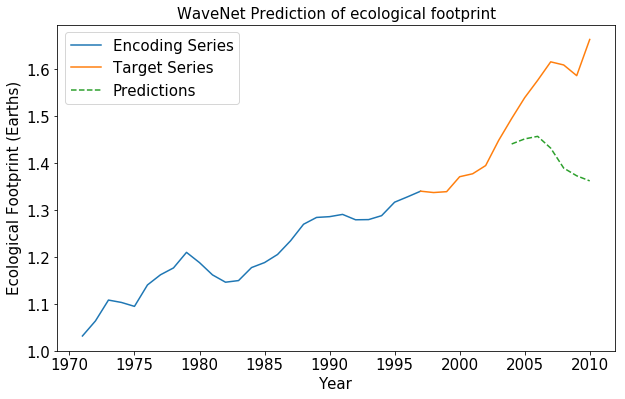

In [68]:
predict_and_plot_all(encoder_input_data, decoder_target_data, pred_target_data, scaler, 14, 
                     int(end_year) - int(decoder_train_start), int(start_year), series,  [-2])

In [ ]:
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import sklearn.preprocessing
start_year = '1971'
end_year = '2010' #2014 for medium, 2010 for big
decoder_train_start = '1996' #2000 for medium, 1996 for big
pred_years = 7
data = get_big()
series = data.columns.values

(182, 7, 1)


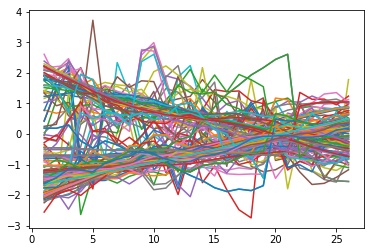

In [36]:
encoder_input_data, decoder_target_data, pred_target, mean_data = transform_series(data, int(start_year), 
                                                                        int(decoder_train_start), pred_years)
# print(np.where(np.isnan(encoder_input_data[:,1,-1])))
# print(np.where(np.isnan(decoder_target_data[:,-1,-1])))
# encoder_input_data = np.delete(encoder_input_data, np.where(np.isnan(encoder_input_data[:,1,-1]))[0], 0)
# decoder_target_data = np.delete(decoder_target_data, np.where(np.isnan(decoder_target_data[:,1,-1]))[0], 0)
# print(np.where(np.isnan(encoder_input_data[:,:,-1])))
# print(np.where(np.isnan(decoder_target_data[:,:,-1])))
# pred_target = np.delete(pred_target, np.where(np.isnan(pred_target[:,1,-1]))[0], 0)
# encoder_input_data = encoder_input_data[:150,:,:]
# decoder_target_data = decoder_target_data[:150,:,:]
# pred_target = pred_target[:150,:,:]
print(decoder_target_data.shape)
for i in range(encoder_input_data.shape[0]-1):
    plt.plot(range(1,encoder_input_data[0,:].size+1),encoder_input_data[i,:].astype(np.float64))

In [37]:
import tensorflow as tf
tf.VERSION

'1.11.0'

In [5]:
# import tensorflow as tf
# tf.reset_default_graph()
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate, BatchNormalization
from keras.optimizers import Adam

# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.5)(x)
x = Dense(1)(x)

# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':7})(x)

model = Model(history_seq, pred_seq_train)

Using TensorFlow backend.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          2080      
__________

In [7]:
first_n_samples = 40000
batch_size = 100
epochs = 40
 
# teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

model.compile(Adam(), loss='mean_squared_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0)

Epoch 1/40
182/182 [==============================] - 1s 8ms/step - loss: 0.5628
Epoch 2/40
182/182 [==============================] - 0s 734us/step - loss: 0.4126
Epoch 3/40
182/182 [==============================] - 0s 758us/step - loss: 0.2696
Epoch 4/40
182/182 [==============================] - 0s 707us/step - loss: 0.2496
Epoch 5/40
182/182 [==============================] - 0s 795us/step - loss: 0.2196
Epoch 6/40
182/182 [==============================] - 0s 773us/step - loss: 0.1625
Epoch 7/40
182/182 [==============================] - 0s 745us/step - loss: 0.1468
Epoch 8/40
182/182 [==============================] - 0s 733us/step - loss: 0.1541
Epoch 9/40
182/182 [==============================] - 0s 740us/step - loss: 0.1415
Epoch 10/40
182/182 [==============================] - 0s 745us/step - loss: 0.1282
Epoch 11/40
182/182 [==============================] - 0s 762us/step - loss: 0.1276
Epoch 12/40
182/182 [==============================] - 0s 816us/step - loss: 0.1166
Epo

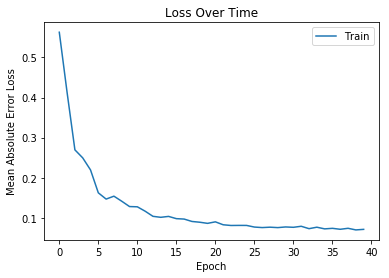

In [8]:
plt.plot(history.history['loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train'])

In [9]:
encoder_input_data, decoder_target_data, pred_target_data, scaler = transform_series(data, int(start_year), 
                                                                             int(decoder_train_start), pred_years)

In [12]:
predict_and_plot_all(encoder_input_data, decoder_target_data, pred_target_data, scaler, 14, 
                     int(end_year) - int(decoder_train_start), int(start_year), series,  [-2])

UnboundLocalError: local variable 'sample_ind' referenced before assignment

In [ ]:
inp = encoder_input_data.reshape(-1,26)
scaler.inverse_transform(inp.T)

In [ ]:
print(encoder_input_data.shape)

In [ ]:
encoder_input_data.shape

In [ ]:
encode_series = encoder_input_data[:,:,:]
pred_series = predict_sequence(encode_series, 14)